<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [69]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import math
import re

# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
import contractions
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Para sistemas de recomendacion basados en cotenido
# -----------------------------------------------------------------------
from scipy.spatial.distance import pdist , squareform   # Para calcular la distancia entre puntos 
from sklearn.feature_extraction.text import CountVectorizer # Vectorizacion / tokenizacion 
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

# Otros
# -----------------------------------------------------------------------
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from src import soporte_nlp as snlp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importación de los datos

In [70]:
df = pd.read_csv("datos/datos.csv", index_col=0)
df.head(2)

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
65115,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
56720,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0


- Filtramos las columnas con las que nos vamos a quedar.

In [71]:
df = df[['mainDepartment', 'subDepartment', 'productName', 'reviewStar', 'reviewText']]

## Paso #1: preprocesamiento del texto

- Instanciamos la clase y limpiamos el texto.

In [72]:
exp_nlp = snlp.ExploracionText(df, "reviewText", "productName")

In [73]:
exp_nlp.limpiar_textos("texto_limpio")

En la columna reviewText hay 1 nulos.
Se han eliminado los nulos de la columna reviewText.
Limpiando el texto...
Texto limpiado y listo.


- Comprobamos el estado final

In [74]:
df = exp_nlp.obtener_dataframe_limpio()
df.sample(5)

,mainDepartment,subDepartment,productName,reviewStar,reviewText,texto_limpio
6735,Computers,Computer Accessories & Peripherals,"seenda Wireless Mouse, 2.4G Noiseless Mouse wi...",2.0,"Looks nice, feels nice, but the cursor is jump...",look nice feel nice cursor jumpy never get mou...
4099,Sports and Outdoors,Outdoor Recreation,Coleman Sundome Tent,1.0,Used this tent twice. Once in the backyard and...,use tent twice backyard actual campground supe...
3189,Home and Kitchen,Furniture,FURINNO Econ Multipurpose Home Office Computer...,1.0,Crap after 2 weeks,crap week
1538,Beauty and Personal Care,"Foot,Hand & Nail Care",Hard As Hoof Nail Strengthening Cream with Coc...,3.0,Just received so I dont know how well it works...,receive know well work yet strong coconut scen...
2722,Computers,Computers & Tablets,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",2.0,Horrible product. Bought it in March and it ke...,horrible product buy march keep disconnect int...


- Eliminamos la columa de texto original.

In [75]:
df.drop(columns= "reviewText", inplace=True)

## Análisis de sentimientos

In [76]:
df_sentimiento = df.copy()

- Aplicamos el SentimentIntensityAnalyzer para identificar el sentido de la opinión.

In [77]:
df_sentimiento["sentiment"] = df_sentimiento["texto_limpio"].apply(snlp.sentimientos)

In [78]:
df_sentimiento.head(1)

,mainDepartment,subDepartment,productName,reviewStar,texto_limpio,sentiment
0,Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,3.0,nice lightweight brace unfortunately large wri...,"{'neg': 0.121, 'neu': 0.603, 'pos': 0.276, 'co..."


In [79]:
df_sentimiento[df_sentimiento["sentiment"].apply(pd.Series).columns] = df_sentimiento["sentiment"].apply(pd.Series)

In [80]:
df_sentimiento.head(1)

,mainDepartment,subDepartment,productName,reviewStar,texto_limpio,sentiment,neg,neu,pos,compound
0,Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,3.0,nice lightweight brace unfortunately large wri...,"{'neg': 0.121, 'neu': 0.603, 'pos': 0.276, 'co...",0.121,0.603,0.276,0.4767


In [81]:
df_sentimiento.drop(columns = "sentiment", inplace=True)

In [82]:
df_sentimiento.head(1)

,mainDepartment,subDepartment,productName,reviewStar,texto_limpio,neg,neu,pos,compound
0,Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,3.0,nice lightweight brace unfortunately large wri...,0.121,0.603,0.276,0.4767


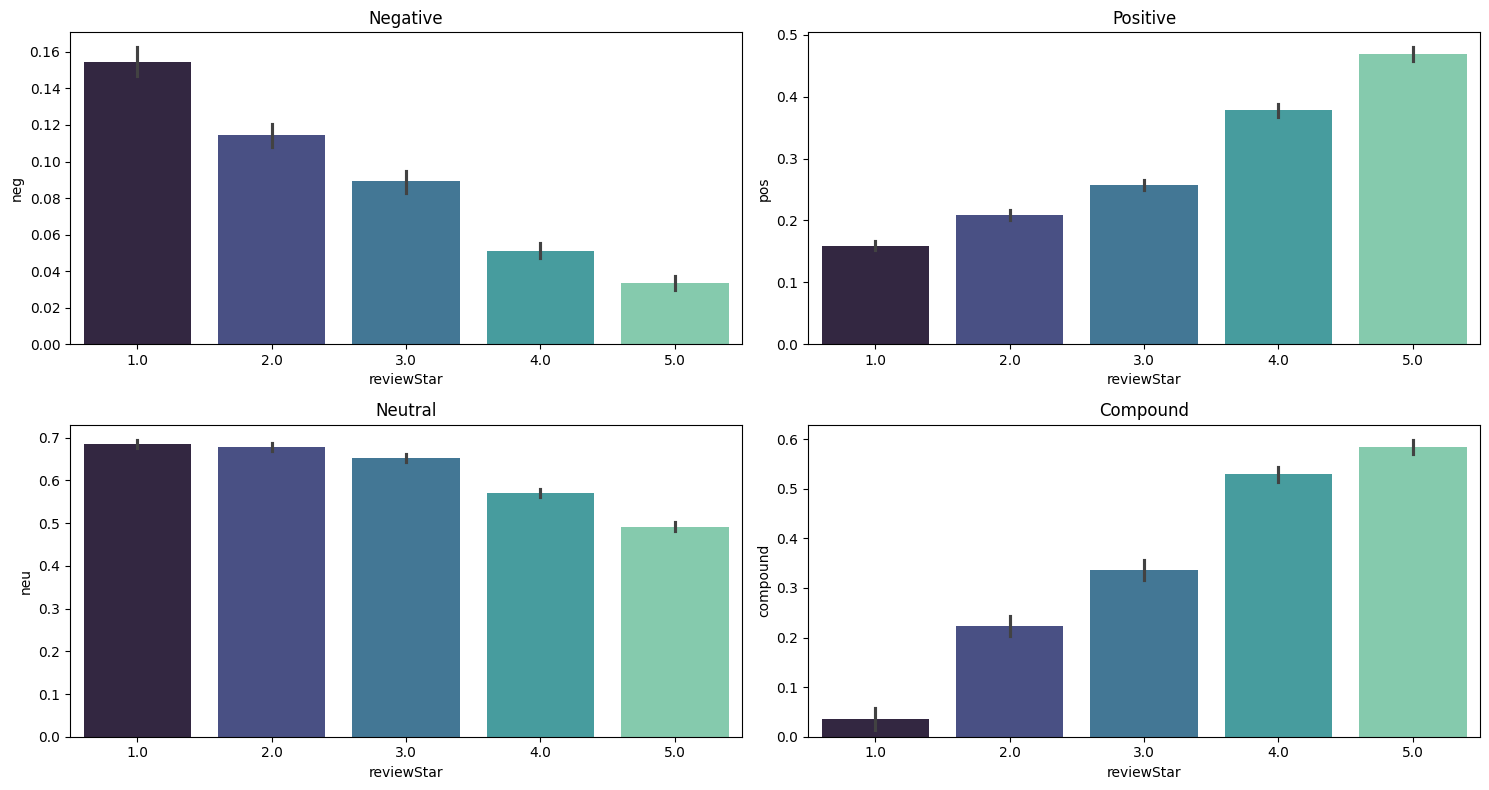

In [83]:
import warnings
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

sns.barplot(ax=axes[0, 0], x='reviewStar', y='neg', data=df_sentimiento, palette='mako')
axes[0, 0].set_title('Negative')

sns.barplot(ax=axes[0, 1], x='reviewStar', y='pos', data=df_sentimiento, palette='mako')
axes[0, 1].set_title('Positive')

sns.barplot(ax=axes[1, 0], x='reviewStar', y='neu', data=df_sentimiento, palette='mako')
axes[1, 0].set_title('Neutral')

sns.barplot(ax=axes[1, 1], x='reviewStar', y='compound', data=df_sentimiento, palette='mako')
axes[1, 1].set_title('Compound')

plt.tight_layout()
plt.show()


In [84]:
df_groupby = df_sentimiento.groupby(['productName', 'mainDepartment', 'subDepartment']).agg({'texto_limpio': ' '.join, 'reviewStar':np.median, 'neg':np.median, 'neu':np.median, 'pos':np.median, 'compound':np.median}).reset_index()
df_groupby['reviewStar'] = df_groupby['reviewStar'].round()
df_groupby.drop(columns = ["neg", "neu", "pos"], inplace=True)
df_groupby.head(5)

,productName,mainDepartment,subDepartment,texto_limpio,reviewStar,compound
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",Electronics,CellPhones and Accessories,admit skeptical review decide purchase anyway ...,3.0,0.2960
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,Beauty and Personal Care,"Foot,Hand & Nail Care",thick work good get use base top coat work gre...,3.0,0.5859
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,Electronics,Camera and Accessories,impressed image quality also app suggest use p...,3.0,0.6059
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",Computers,Computers & Tablets,laptop arrive time school work great product d...,3.0,0.2263
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Computers,Computers & Tablets,buy school work good farsleek alright buy lapt...,3.0,0.3612


In [85]:
lista_productos = df['productName'].tolist()

Mostrando productos similares a Sabrent 4-Port USB 2.0 Hub with Individual LED lit Power Switches (HB-UMLS)


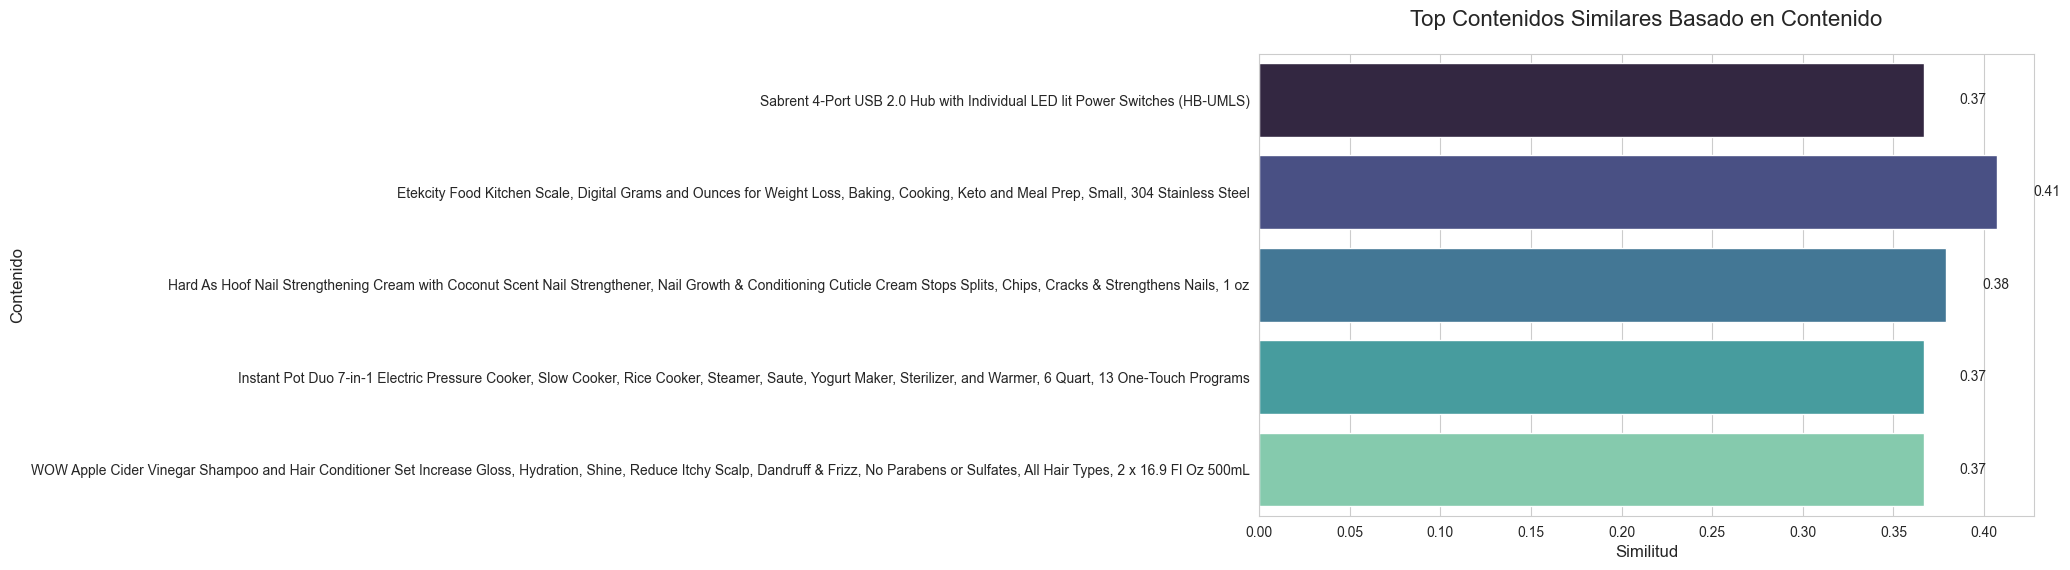

In [88]:
producto = random.choice(lista_productos)
snlp.buscar_similares(df, producto, snlp.vectorizar(df, 'texto_limpio', 1000), 'productName')